### Importação das Bibliotecas

In [1]:
# Tratamento dos dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose

# Ciência de Dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Biblioteca do Prophet - Modelo de Projeção
from prophet import Prophet
from prophet.plot import plot, plot_plotly, plot_components_plotly, add_changepoints_to_plot
from prophet.plot import add_changepoints_to_plot, plot_seasonality, plot_cross_validation_metric
from prophet.diagnostics import cross_validation

### Importação e Descrição dos Dados

In [2]:
# Possibilidades de analise
# - vendas por artigo
# - vende menos os itens quando o valor dele é maior
# - quando ocorre o aumento/diminuicao do valor do produto

In [3]:
df = pd.read_csv('bakery_sales.csv', index_col=0)

# Update datatypes and data processing
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format='%H:%M').dt.time

df['Quantity'] = df['Quantity'].apply(lambda x: abs(int(x)))
df['Quantity'] = df['Quantity'].astype(int)

df['unit_price'] = df['unit_price'].str[:-2]
df['unit_price'] = df['unit_price'].str.replace(",",".")
df['unit_price'] = df['unit_price'].astype(float)

df['ticket_number'] = df['ticket_number'].astype(int)

# Cria coluna do total da compra
df['total_bill'] = df['Quantity'] * df['unit_price']

# Como nesse momento não será feita uma análise por produto, a coluna sera dropada
df.rename(columns={'Quantity':'quantity'}, inplace=True)
df_backup = df.copy()
df.drop(columns=['article', 'unit_price'], inplace=True)
df.head()

,date,time,ticket_number,quantity,total_bill
0,2021-01-02,08:38:00,150040,1,0.90
1,2021-01-02,08:38:00,150040,3,3.60
4,2021-01-02,09:14:00,150041,2,2.40
5,2021-01-02,09:14:00,150041,1,1.15
8,2021-01-02,09:25:00,150042,5,6.00


In [4]:
# Agrupa os dados por ticket (nota fiscal)
df_grouped = df.groupby(by=('ticket_number')).agg({'date':'first',
                                                   'time':'first',
                                                   'quantity':'sum',
                                                   'total_bill':'sum'})

df_grouped.reset_index(inplace=True)

df_grouped.head()

,ticket_number,date,time,quantity,total_bill
0,150040,2021-01-02,08:38:00,4,4.50
1,150041,2021-01-02,09:14:00,3,3.55
2,150042,2021-01-02,09:25:00,5,6.00
3,150043,2021-01-02,09:25:00,5,5.10
4,150044,2021-01-02,09:27:00,1,1.05


In [5]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136451 entries, 0 to 136450
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ticket_number  136451 non-null  int32         
 1   date           136451 non-null  datetime64[ns]
 2   time           136451 non-null  object        
 3   quantity       136451 non-null  int32         
 4   total_bill     136451 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 4.2+ MB


#### Novas Features

In [6]:
# Novas Variaves, para analise
df = df_grouped.copy()

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['day_week'] = df.date.dt.day_of_week
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour

# Cria um dataset com dados diarios
df_daily = df_grouped[['date', 'quantity', 'total_bill']].groupby('date').sum().reset_index()

df_daily['year'] = df_daily.date.dt.year
df_daily['month'] = df_daily.date.dt.month
df_daily['day'] = df_daily.date.dt.day
df_daily['day_week'] = df_daily.date.dt.day_of_week

df.head()

,ticket_number,date,time,quantity,total_bill,year,month,day,day_week,hour
0,150040,2021-01-02,08:38:00,4,4.50,2021,1,2,5,8
1,150041,2021-01-02,09:14:00,3,3.55,2021,1,2,5,9
2,150042,2021-01-02,09:25:00,5,6.00,2021,1,2,5,9
3,150043,2021-01-02,09:25:00,5,5.10,2021,1,2,5,9
4,150044,2021-01-02,09:27:00,1,1.05,2021,1,2,5,9


### Analise Exploratória

In [10]:
# Cria paleta de cores para utilizar ao longo do projeto
palette1 = sns.color_palette("rocket", 2) # paleta com apenas duas cores, para gráficos de linhas
palette2 = sns.color_palette("rocket_r", 12) # paleta com 12 cores, principalmente para quando tiver os meses do ano

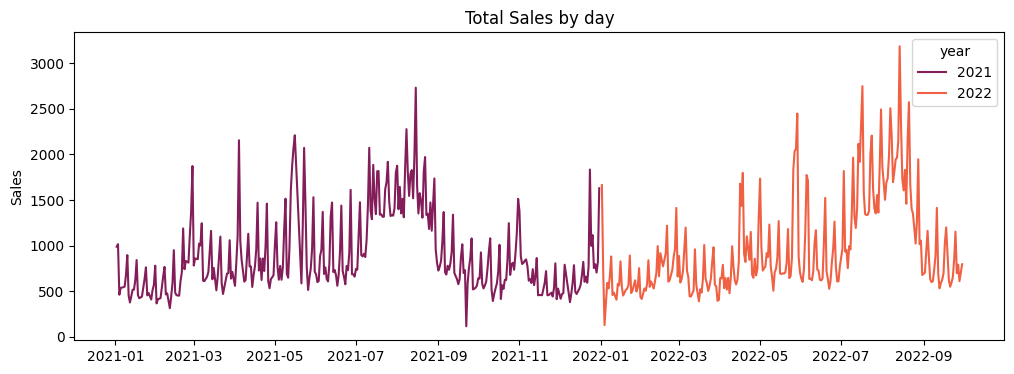

In [12]:
# Comportamento dos Dados e Padrões

fig = plt.figure(figsize=(12,4))

sns.lineplot(df_daily, x='date', y='total_bill', hue='year', palette=palette1)
plt.title('Total Sales by day')
plt.xlabel('')
plt.ylabel('Sales')
plt.show()

#### Anual

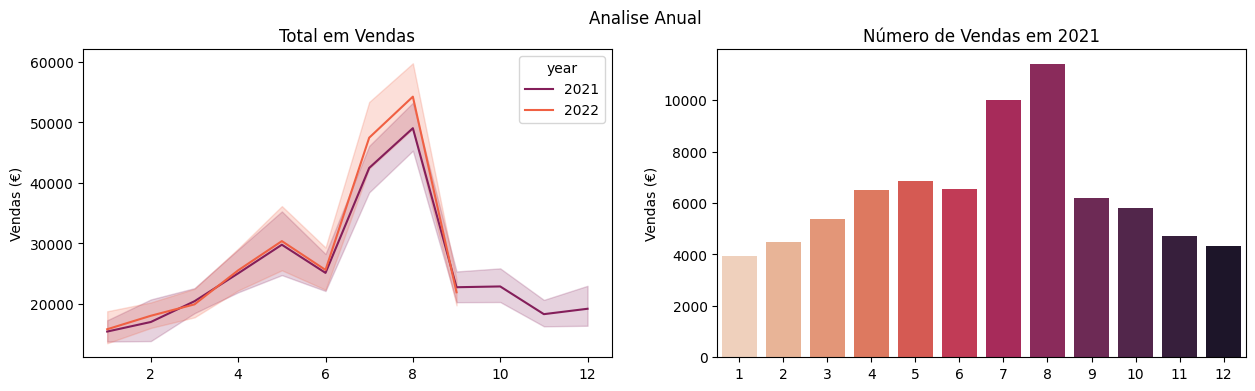

In [18]:
fig = plt.subplots(1,2, figsize=(15,4))

plt.subplot(1,2,1)
ax = sns.lineplot(df_daily, x='month', y='total_bill', estimator='sum', hue='year', palette=palette1)
plt.title('Total em Vendas')
plt.xlabel('')
plt.ylabel('Vendas (€)')

plt.subplot(1,2,2)
ax = sns.countplot(df.loc[df.year == 2021], x='month', palette=palette2)
plt.title('Número de Vendas em 2021')
plt.xlabel('')
plt.ylabel('Vendas (€)')

plt.suptitle('Analise Anual')

plt.show()

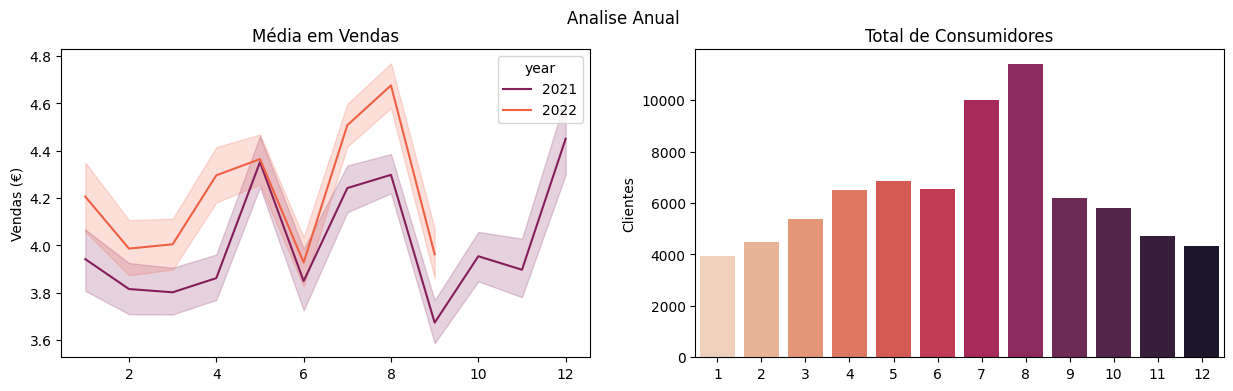

In [29]:
fig = plt.subplots(1,2, figsize=(15,4))

plt.subplot(1,2,1)
ax = sns.lineplot(df, x='month', y='total_bill', estimator='mean', hue='year', palette=palette1)
plt.title('Média em Vendas')
plt.xlabel('')
plt.ylabel('Vendas (€)')

plt.subplot(1,2,2)
ax = sns.countplot(df.loc[df.year == 2021], x='month', palette=palette2)
plt.title('Total de Consumidores')
plt.xlabel('')
plt.ylabel('Clientes')

plt.suptitle('Analise Anual')

plt.show()

#### Mensal

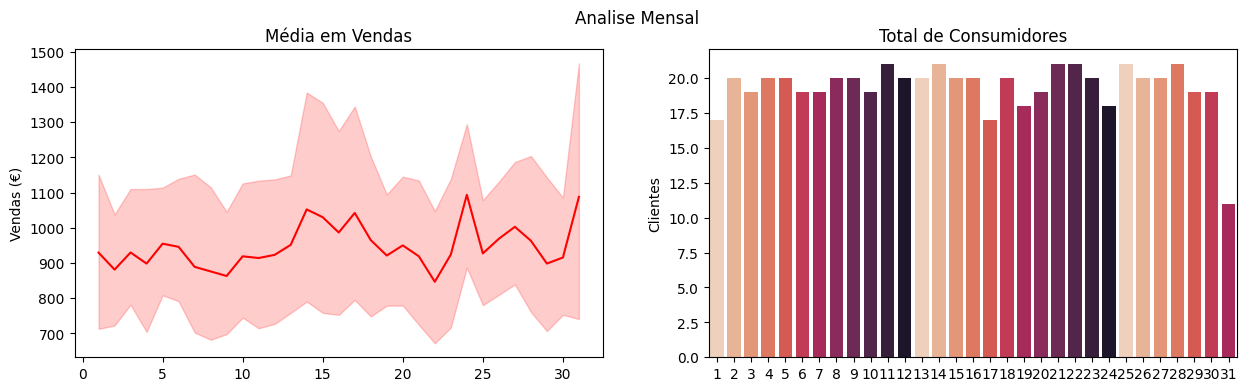

In [28]:
fig = plt.subplots(1,2, figsize=(15,4))

plt.subplot(1,2,1)
ax = sns.lineplot(df_daily, x='day', y='total_bill', estimator='mean', color='red')
plt.title('Média em Vendas')
plt.xlabel('')
plt.ylabel('Vendas (€)')

plt.subplot(1,2,2)
ax = sns.countplot(df_daily, x='day', palette=palette2)
plt.title('Total de Consumidores')
plt.xlabel('')
plt.ylabel('Clientes')

plt.suptitle('Analise Mensal')

plt.show()

Text(0, 0.5, 'Clientes')

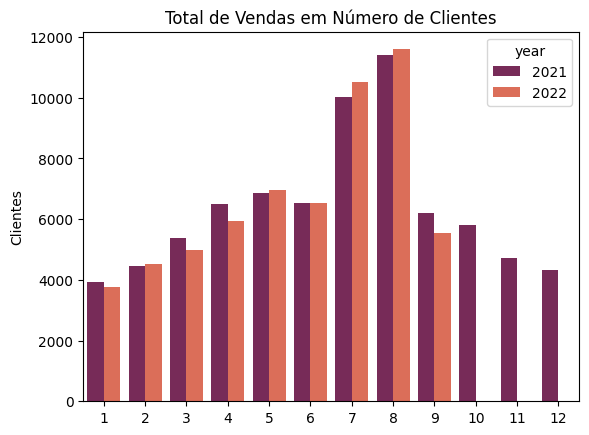

In [15]:
ax = sns.countplot(df, x='month', hue='year', palette=palette1)
plt.title('Total de Vendas em Número de Clientes')
plt.xlabel('')
plt.ylabel('Clientes')

#### Semanal

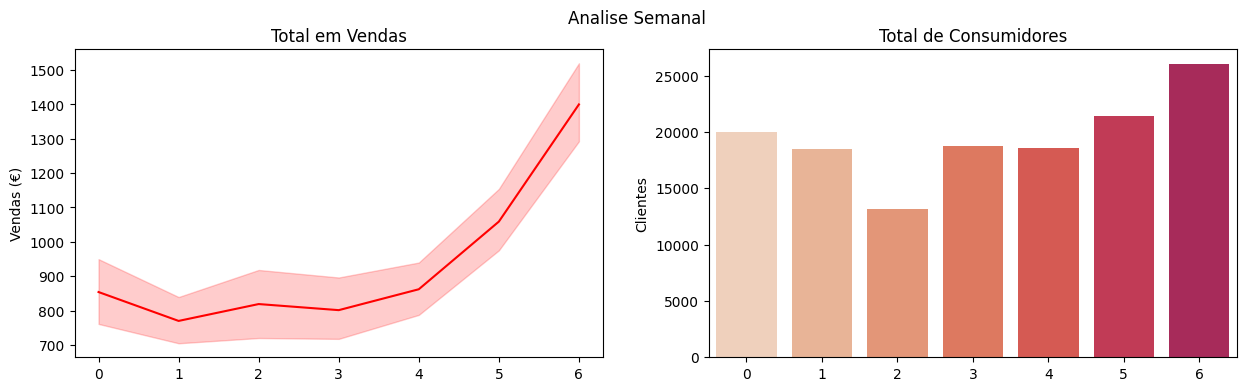

In [27]:
fig = plt.subplots(1,2, figsize=(15,4))

plt.subplot(1,2,1)
ax = sns.lineplot(df_daily, x='day_week', y='total_bill', estimator='mean', color='red')
plt.title('Total em Vendas')
plt.xlabel('')
plt.ylabel('Vendas (€)')

plt.subplot(1,2,2)
ax = sns.countplot(df, x='day_week', palette=palette2)
plt.title('Total de Consumidores')
plt.xlabel('')
plt.ylabel('Clientes')

plt.suptitle('Analise Semanal')

plt.show()

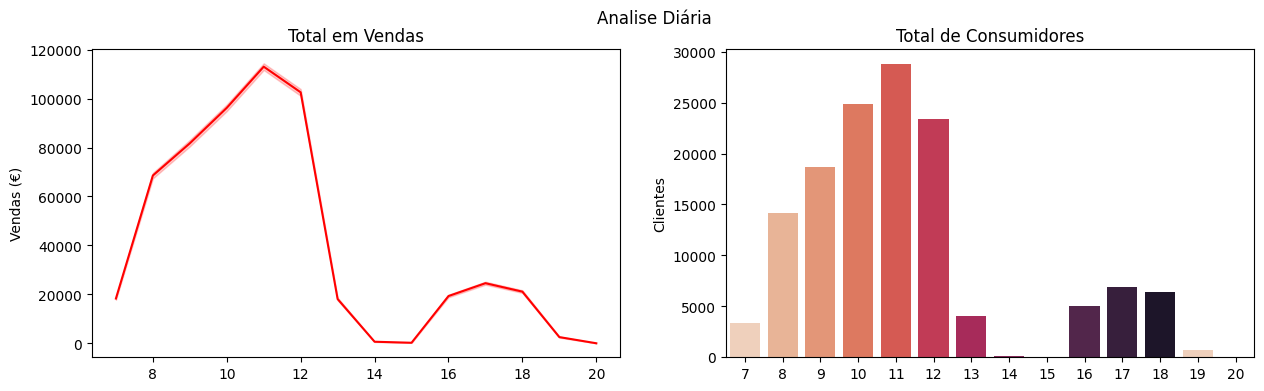

In [33]:
fig = plt.subplots(1,2, figsize=(15,4))

plt.subplot(1,2,1)
ax = sns.lineplot(df, x='hour', y='total_bill', estimator='sum', color='red')
plt.title('Total em Vendas')
plt.xlabel('')
plt.ylabel('Vendas (€)')

plt.subplot(1,2,2)
ax = sns.countplot(df, x='hour', palette=palette2)
plt.title('Total de Consumidores')
plt.xlabel('')
plt.ylabel('Clientes')

plt.suptitle('Analise Diária')

plt.show()

#### Resumo descritivo análise exploratória

**Resumo de algumas constatações e padrões identificados nas visualizações:**

Há uma grande oscilação no total de vendas por dia, entretanto, alguns padrões são possíveis de serem notados.

- Os meses de Julho e Agosto são os de maior total em venda e maior número de clientes (pode ser devido ao período de verão e férias escolares na França.)
- A média de consumo por venda também é maior em Julho e Agosto. Maio é o mes que se destaca no primeiro semestre.
- A venda média por consumidor parece ter aumentado na maioria dos meses de 2022, apesar de as vendas totais por mês não terem aumentado tanto na comparação YoY.
- O número de consumidores diminuiu de 2021 para 2022 nos meses de Jan a Abril, e começam a crescer nos meses seguintes.
- Domingo é o dia com maior número de clientes e também total em vendas. 
- Apesar de sábado não aumentar significativamente em número de clientes, o total de vendas é maior que nos demais dias da semana, o que indica que as pessoas consomem mais por compra nesse dia.
- Ao longo do dia, é das 8 as 12hs da manhã que se concentra o maior movimento. O pico de vendas em valores acontece entre 11 e 13hs.
- Pode parecer que os clientem gastam mais as 14hs, porem temos poucos dados nesse horário, o que gera uma baixa confiança.

A ser verificado posteriormente:
- No análise anual diária, parece haver picos de vendas em datas próximas a feriados ou datas especiais.


#### Quantidade de Itens

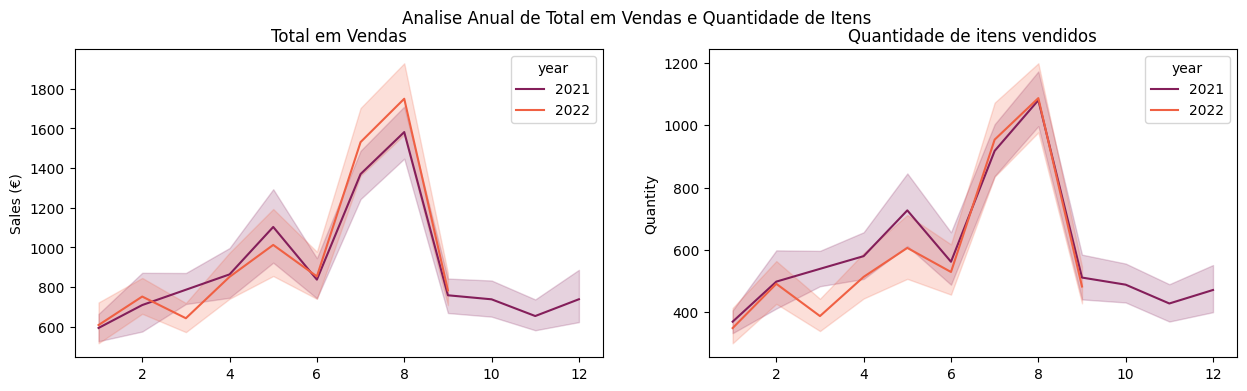

In [34]:
fig = plt.subplots(1,2, figsize=(15,4))

plt.subplot(1,2,1)
ax = sns.lineplot(df_daily, x='month', y='total_bill', estimator='mean', hue='year', palette=palette1)
plt.title('Total em Vendas')
plt.xlabel('')
plt.ylabel('Sales (€)')

plt.subplot(1,2,2)
ax = sns.lineplot(df_daily, x='month', y='quantity', estimator='mean', hue='year', palette=palette1)
plt.title('Quantidade de itens vendidos')
plt.xlabel('')
plt.ylabel('Quantity')

plt.suptitle('Analise Anual de Total em Vendas e Quantidade de Itens')

plt.show()

- Podemos segmentar nossa análise dos gráficos acima em dois períodos:
    - Primeiro Semestre do Ano: Tanto a receita como a quantidade de itens vendidos diminuiu de 2021 para 2022, com destaque para a quantidade de itens que proporcionalmente parece ter diminuído mais.

    - Segundo Semestre do Ano: apesar de a receita média por mês ser maior em 2022, a quantidade de itens vendidos parece ser a muito próxima do ano anterior. O aumento na receita ter acontecido devido a um aumento no valor unitário dos produtos ou alguma alteração de estratégia comercial.

Abaixo é explorada a hipótese apresentada na justificativa do segundo semestre.  

In [35]:
# Cria colunas no dataframe de backup para faer agrupamento por item
df_backup['year'] = df_backup['date'].dt.year
df_backup['month'] = df_backup['date'].dt.month
df_backup.head()

,date,time,ticket_number,article,quantity,unit_price,total_bill,year,month
0,2021-01-02,08:38:00,150040,BAGUETTE,1,0.90,0.90,2021,1
1,2021-01-02,08:38:00,150040,PAIN AU CHOCOLAT,3,1.20,3.60,2021,1
4,2021-01-02,09:14:00,150041,PAIN AU CHOCOLAT,2,1.20,2.40,2021,1
5,2021-01-02,09:14:00,150041,PAIN,1,1.15,1.15,2021,1
8,2021-01-02,09:25:00,150042,TRADITIONAL BAGUETTE,5,1.20,6.00,2021,1


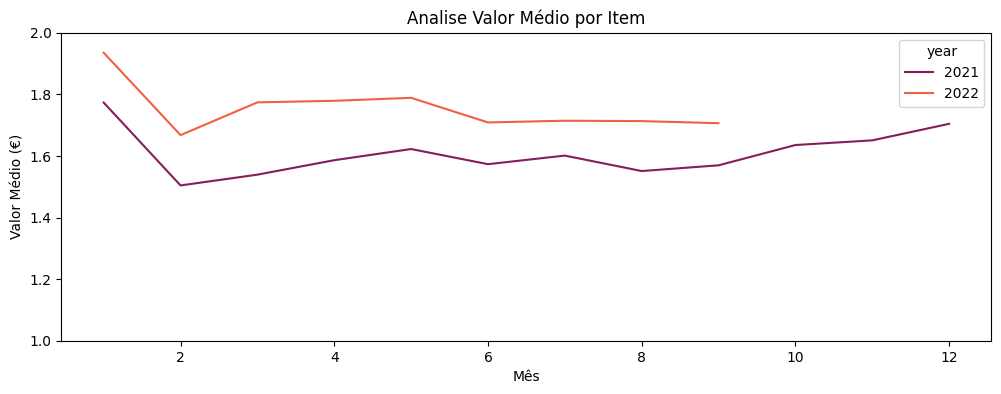

In [40]:
# Agrupa o dataset para criar a visualização
df_backup_g = df_backup[['year', 'month', 'unit_price']].groupby(['year', 'month']).mean().reset_index()

# Gera a visualização
plt.figure(figsize=(12,4))
ax = sns.lineplot(df_backup_g, x='month', y='unit_price', hue='year', palette=palette1)
plt.title('Analise Valor Médio por Item')
plt.xlabel('Mês')
plt.ylim([1,2])
plt.ylabel('Valor Médio (€)')
plt.show()

Inicialmente sim, o gráfico acima indica que o valor médio por item em 2022 é superior aos valores de 2021. 

Entretanto, no gráfico "Quantidade de itens vendidos" apresentado anteriormente, é possível notar que no segundo semestre de 2022 o número de itens vendidos se aproximou dos valores desse mesmo período em 2021, enquanto no primeiro semestre de 2022 os valores são menores nessa comparação ano versus ano.

Para aumentar o detalhamento, seguem algumas sugestões de análise por item, considerando:
- Comportamento dos clientes:
    - a quantidade de itens vendidos, por tipo de produto, alterou-se de 2021 para 2022? Ou seja, em 2022 os clientes tem consumidos produtos de ticket médio maior, gerando um aumento no valor por compra ?

Informações que ajudariam a compreender melhor o cenário (porém não estão disponíveis):
- Alteração de Apresentação, Estratégia ou Cardápio:
    - no segundo semestre de 2022 a loja apresentou nova apresentação dos produtos (incentivando os clientes a comprarem mais) ?
    - há implementação de uma estratégia comercial no 2º semestre de 2022 que justifique o aumento no número de clientes?
    - nesse mesmo período, houve alguma alteração no cardápio que possa justificar os fatos?

Tais ideias, neste momento, não serão exploradas no estudo aqui apresentado, mas ficam como possíveis "próximos passos".

### Análise estatistica

#### Análise Descritiva e Distribuição ⚠️

- Distribuição dos valores de vendas
- Medidas de Tendência Central e Dispersão
- Visualização através de histogramas e boxplots

In [23]:
# Disitrbuição dos valores por dia

fig = px.line(df_daily, x='date', y='total_bill', width=1200, height=500, color='year',
              title='Vendas por Dia', hover_data='day_week',
              labels={
                     "total_bill": "Vendas em €",
                     "year": "Ano",
                     "date": ""
                 },)
fig.add_hline(y=2000)
fig.show()

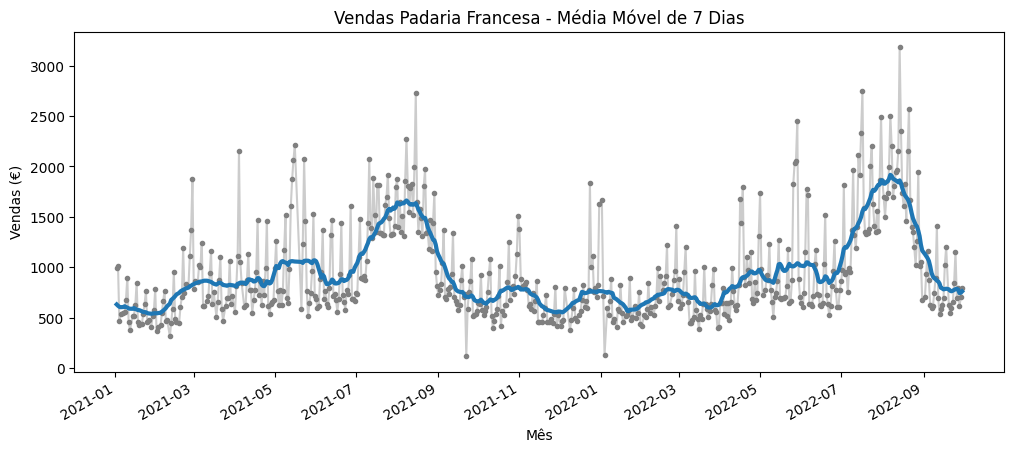

In [43]:
# Analysiong and calculating the mooving average
moving_average = df_daily[['date', 'total_bill']].set_index('date').rolling(
    window=30,       # 7-day window
    center=True,      # puts the average at the center of the window
    min_periods=4,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df_daily[['date', 'total_bill']].set_index('date').plot(y='total_bill', style="-", color="0.8", figsize=(12,5), legend=False)
ax = df_daily[['date', 'total_bill']].set_index('date').plot(ax=ax, y='total_bill', style=".", color="0.5", figsize=(12,5), legend=False)
moving_average.plot(
    ax=ax, linewidth=3, title="Vendas Padaria Francesa - Média Móvel de 7 Dias", legend=False)
plt.ylabel('Vendas (€)')
plt.xlabel('Mês')
plt.show()

In [44]:
# Medidas de Tendência Central e Dispersão
df_daily['total_bill'].describe()

count     600.000000
mean      944.654250
std       479.961217
min       116.000000
25%       612.850000
50%       769.900000
75%      1189.337500
max      3184.100000
Name: total_bill, dtype: float64

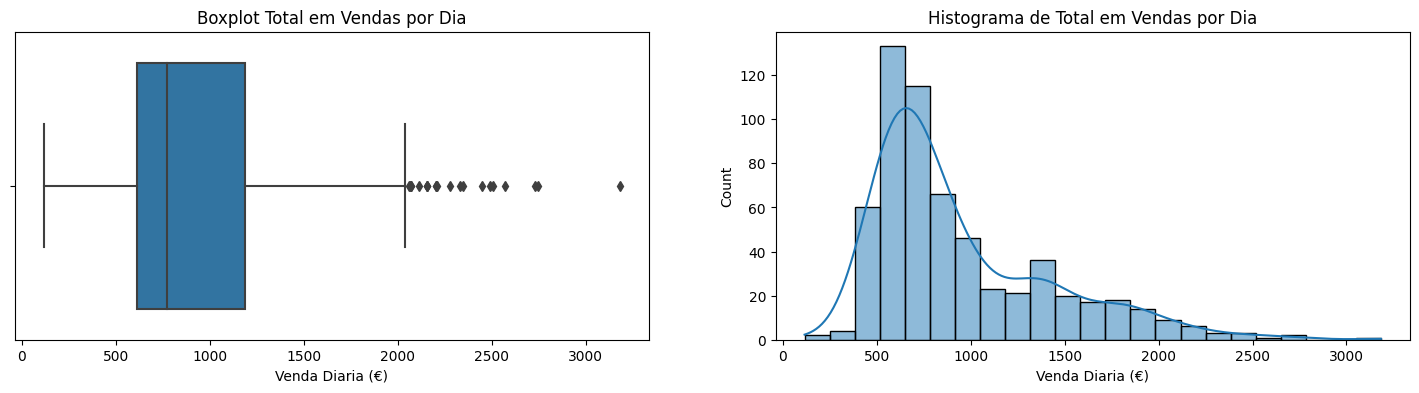

In [45]:
# Visualização através de histogramas e boxplots
fig = plt.subplots(1,2, figsize=(18,4))

plt.subplot(1,2,1)
sns.boxplot(df_daily, x='total_bill') #hue='year', palette=palette1
plt.title('Boxplot Total em Vendas por Dia')
plt.xlabel('Venda Diaria (€)')

plt.subplot(1,2,2)
sns.histplot(df_daily, x='total_bill', kde=True) #hue='year', palette=palette1
plt.title('Histograma de Total em Vendas por Dia')
plt.xlabel('Venda Diaria (€)')
plt.show()

In [46]:
# Teste de Shapiro-Wilk

from scipy.stats import shapiro

data = df_daily['total_bill']
stat = shapiro(data)

print('Estatística W: %f' % stat.statistic)
print('Valor-p: %f' % stat.pvalue)

Estatística W: 0.864341
Valor-p: 0.000000


**Resumo das Observações**

- O total de vendas por dia apresenta um forte padrão de comportamento, repetindo os picos em meses semelhantes no YoY.
- No que refere as medidas de tendência central: 
    - Média de: € 944,65
    - Mediana de: € 769,90
    - Desvio Padrão de: € 479
- Como a média e mediana estão distantes (e a mediana é menor que a média) temos uma distribuição assimétrica à direita (possível notar também pelo histograma).
- O teste de Shapiro reforça a ideia de que nossa distribuição não é normal, pois o p-value é menor que 0.05 esperado. ⚠️⚠️⚠️⚠️ REVISAR
- Além disso, a grande concentração de dados diários está entre 126 e 2000 €, aproximadamente 3% dos dados podem ser considerados outliers (pelo gráfico inicial, tais dados parecem se concentram em datas festivas e feriados).

#### Análise da Sazonalidade e Tendência:

- Decomposição dos dados em tendências, sazonalidades e resíduos.
- Teste estatístico para verificar a estacionaridade (Augmented Dickey-Fuller (ADF)).

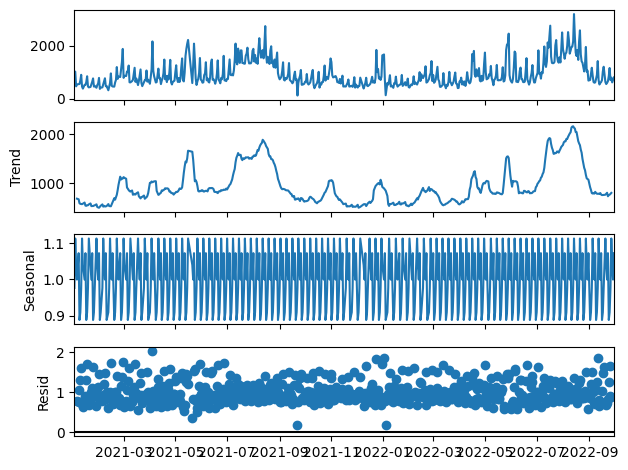

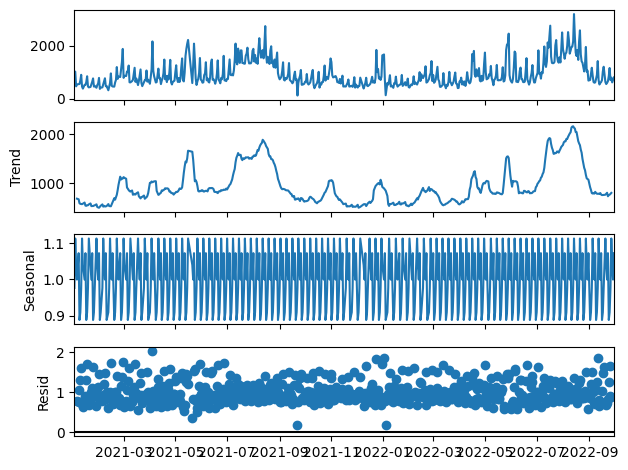

In [47]:
# Decomposição dos dados em tendências, sazonalidades e resíduos.
decomposed_serie = seasonal_decompose(df_daily[['date', 'total_bill']].set_index('date'), model='multiplicative', period=7)
decomposed_serie.plot()

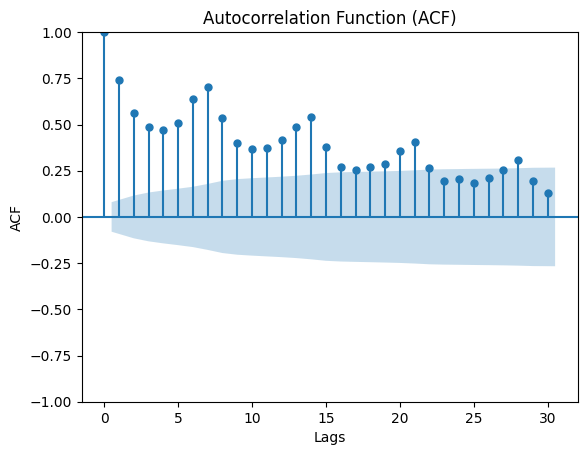

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
# Plotando o ACF
plot_acf(df_daily[['date','total_bill']].set_index('date'), lags=30)  # Aqui define o número de defasagens (lags) a serem exibidos
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
plt.show()

In [49]:
# # Teste de estacionaridade
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_daily['total_bill'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.149985
p-value: 0.023069


**Resumo:**

- Pelo gráfico de ACF, observamos uma autocorrelação significativa nos dados de vendas, indicando a presença de padrões temporais nas observações. Essa autocorrelação sugere que as vendas em um determinado dia estão correlacionadas com as vendas em dias anteriores, o que pode ser útil na construção de um modelo de previsão.

- Além disso, pelo teste de Augmented Dickey-Fuller, podemos confirmar que a série é estacionária (valor ADF significativamente negativo e p-value menor que 0.05).

#### Feature Engineering e Seleção de Variáveis: 

- Ideia de algumas variaveis que podem ser incluídas no modelo de predição:
 
    - *média móvel das vendas e número de compras por dia:* vale ressaltar que essas variaveis não estão disponíveis para valores futuros, caso seja de interesse utilizá-las, seria necessário uma predição previamente para então implementar o resulta no novo modelo. Esse proceso só é sugerido quando implementar uma predição numa variavel para ela ser utilizada como feature, foi mais fácil e assertivo, caso contrário pode gerar muitos ruídos e incertezas.
    
    - *média do valor por item:* como este valor é menos flutuante, pode ser mais facilmente ajustado para meses futuros próximos.

As sugestões acima não foram implementadas neste estudo e ficam de sugestão para próximos passos num segundo momento.